# Simple scikitlearn for Allstate.
Just a simple linear regression with scikit. Well, that's how it started

ok, not so simple. I seem to keep adding junk.  currently using a several regressions, and plan to add in some nice gridsearch, etc.

In [1]:
import os,sys,time,random,math,time
import tarfile, zipfile

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn import decomposition, datasets, ensemble
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import matplotlib.pyplot as plt
from IPython.display import display, Image

import xgboost as xgb


from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

sample_submission.csv
test.csv
train.csv



/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Some functions we use...

In [2]:
def loadData(datadir,filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std
        
def LabelEncoder(data):
    # lifted in parts from:
    #https://www.kaggle.com/mmueller/allstate-claims-severity/yet-another-xgb-starter/code
    features = data.columns
    cats = [feat for feat in features if 'cat' in feat]
    for feat in cats:
        data[feat] = pd.factorize(data[feat], sort=True)[0]
    return data

# XGB!

def xgbfit(X_train,y_train):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    

    xgb_params = {
        'seed': 0,
        'colsample_bytree': 0.7,
        'silent': 1,
        'subsample': 0.7,
        'learning_rate': 0.075,
        'objective': 'reg:linear',
        'max_depth': 6,
        'num_parallel_tree': 1,
        'min_child_weight': 1,
        'eval_metric': 'mae',
    }

    start_time = time.time()
    res = xgb.cv(xgb_params, dtrain, num_boost_round=750, nfold=4, seed=42, stratified=False,
                 early_stopping_rounds=15, verbose_eval=100, show_stdv=True, maximize=False)
    print("fit time:{}s".format(round((time.time()-start_time), 3) ))

    best_nrounds = res.shape[0] - 1
    cv_mean = res.iloc[-1, 0]
    cv_std = res.iloc[-1, 1]
    print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))
    # XGB Train!
    start_time = time.time()
    gbdt = xgb.train(xgb_params, dtrain, best_nrounds)
    print("Train time:{}s".format(round((time.time()-start_time), 3) ))
    return gbdt

## Load the data!

In [3]:
datadir="../input/"
data = loadData(datadir,'train.csv')
display(data.info())
display(data.head(5))

test_data= loadData(datadir,'test.csv') 
display(test_data.info())
display(test_data.head(5))

loading: ../input/train.csv
Dataset has 188318 samples with 132 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


loading: ../input/test.csv
Dataset has 125546 samples with 131 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125546 entries, 0 to 125545
Columns: 131 entries, id to cont14
dtypes: float64(14), int64(1), object(116)
memory usage: 125.5+ MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


## Let's just take a moment with our data

In [4]:
#lets take a moment for the data
features = data.columns
cats = [feat for feat in features if 'cat' in feat]
conts = [feat for feat in features if 'cont' in feat]
print("total features:",len(features),"categories:",len(cats)," continuous:", len(conts))
print("average loss:",data['loss'].mean())
for feat in conts:
    print("Avg value for:",feat,data[feat].mean()) 
print(data[conts].mean())

total features: 132 categories: 116  continuous: 14
average loss: 3037.3376856699792
Avg value for: cont1 0.49386136456420987
Avg value for: cont2 0.507188356179888
Avg value for: cont3 0.49891845072125063
Avg value for: cont4 0.4918123025893598
Avg value for: cont5 0.48742772878311985
Avg value for: cont6 0.4909445337355038
Avg value for: cont7 0.4849702050680532
Avg value for: cont8 0.4864373158700422
Avg value for: cont9 0.48550631989515086
Avg value for: cont10 0.4980658504230596
Avg value for: cont11 0.4935110085548004
Avg value for: cont12 0.4931504256257928
Avg value for: cont13 0.4931376158360079
Avg value for: cont14 0.49571701797489537
cont1     0.493861
cont2     0.507188
cont3     0.498918
cont4     0.491812
cont5     0.487428
cont6     0.490945
cont7     0.484970
cont8     0.486437
cont9     0.485506
cont10    0.498066
cont11    0.493511
cont12    0.493150
cont13    0.493138
cont14    0.495717
dtype: float64


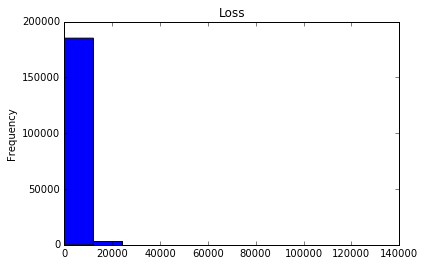

In [5]:
data['loss'].plot(kind='hist',title='Loss')

In [6]:
# hm....are all the values in the test_data seen in the train data?
for c in cats:
    values={}
    for v in data[c]:
        if v in values:
            values[v]+=1
        else:
            values[v]=1
    for v in test_data[c]:
        if v not in values:
            print(c,v,"not found in test!")
# hint...no they are not!

cat89 F not found in test!
cat89 F not found in test!
cat92 G not found in test!
cat92 E not found in test!
cat92 E not found in test!
cat96 H not found in test!
cat99 U not found in test!
cat103 M not found in test!
cat106 Q not found in test!
cat109 AD not found in test!
cat109 AD not found in test!
cat110 BH not found in test!
cat110 CA not found in test!
cat110 EN not found in test!
cat111 L not found in test!
cat113 AA not found in test!
cat113 R not found in test!
cat116 AQ not found in test!
cat116 EM not found in test!
cat116 FY not found in test!
cat116 AI not found in test!
cat116 N not found in test!
cat116 ET not found in test!
cat116 KO not found in test!
cat116 BJ not found in test!
cat116 IW not found in test!
cat116 DB not found in test!
cat116 LP not found in test!
cat116 MX not found in test!
cat116 BR not found in test!
cat116 LP not found in test!
cat116 BH not found in test!
cat116 JS not found in test!
cat116 KO not found in test!
cat116 ER not found in test!
cat1

## Pre Proccessing

In [7]:
# combine the two frames so we can encode the labels!
test_data['loss']=0

lengthofData=len(data)
lengthoftest_data=len(test_data)

combineddata=pd.concat([data,test_data])
lengthofcombined=len(combineddata)

# lets have a look at the results to make sure everything matched back up!
display(combineddata.info())
display(combineddata.head())

print("data:",lengthofData)
print("test:",lengthoftest_data)
print("combined:",lengthofcombined)
print("next two frames should match")
display(test_data.head())
display(combineddata.iloc[lengthofData:].head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313864 entries, 0 to 125545
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 318.5+ MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


data: 188318
test: 125546
combined: 313864
next two frames should match


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,4,A,B,A,A,A,A,A,A,B,...,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562,0
1,6,A,B,A,B,A,A,A,A,B,...,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045,0
2,9,A,B,A,B,B,A,B,A,B,...,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232,0
3,12,A,A,A,A,B,A,A,A,A,...,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955,0
4,15,B,A,A,A,A,B,A,A,A,...,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823,0


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,4,A,B,A,A,A,A,A,A,B,...,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562,0.0
1,6,A,B,A,B,A,A,A,A,B,...,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045,0.0
2,9,A,B,A,B,B,A,B,A,B,...,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232,0.0
3,12,A,A,A,A,B,A,A,A,A,...,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955,0.0
4,15,B,A,A,A,A,B,A,A,A,...,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823,0.0


In [8]:
# the categorical data that we need in a number format
combineddata=LabelEncoder(combineddata)
display(combineddata.info())
display(combineddata.head())
display(combineddata.iloc[lengthofData:].head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313864 entries, 0 to 125545
Columns: 132 entries, id to loss
dtypes: float64(15), int64(117)
memory usage: 318.5 MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,0,1,0,1,0,0,0,0,1,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,0,1,0,0,0,0,0,0,1,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,0,1,0,0,1,0,0,0,1,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,1,1,0,1,0,0,0,0,1,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,0,1,0,1,0,0,0,0,1,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,4,0,1,0,0,0,0,0,0,1,...,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562,0.0
1,6,0,1,0,1,0,0,0,0,1,...,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045,0.0
2,9,0,1,0,1,1,0,1,0,1,...,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232,0.0
3,12,0,0,0,0,1,0,0,0,0,...,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955,0.0
4,15,1,0,0,0,0,1,0,0,0,...,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823,0.0


In [9]:
display(combineddata.info())
display(combineddata.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313864 entries, 0 to 125545
Columns: 132 entries, id to loss
dtypes: float64(15), int64(117)
memory usage: 318.5 MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,0,1,0,1,0,0,0,0,1,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,0,1,0,0,0,0,0,0,1,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,0,1,0,0,1,0,0,0,1,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,1,1,0,1,0,0,0,0,1,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,0,1,0,1,0,0,0,0,1,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [10]:
# time to split the data back apart!

data=combineddata.iloc[:lengthofData].copy()
test_data=combineddata.iloc[lengthofData:].copy()
test_data.drop(['loss'],1,inplace=True) # didn't have this column before, make it go away!

print("origdata:",lengthofData)
print("origtest:",lengthoftest_data)
lengthofData=len(data)
lengthoftest_data=len(test_data)
print("newdata:",lengthofData)
print("newtest:",lengthoftest_data)

origdata: 188318
origtest: 125546
newdata: 188318
newtest: 125546


In [11]:
# we don't want the ID columns in X, and of course not loss either
x=data.drop(['id','loss'],1).fillna(value=0)
# loss is our label
y=data['loss']

display(x.head(5))
display(y.head(5))
display(x.head(5))

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,1,0,0,0,0,1,0,...,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0,1,0,0,0,0,0,0,1,1,...,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,0,1,0,0,1,0,0,0,1,1,...,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,1,1,0,1,0,0,0,0,1,0,...,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,0,1,0,1,0,0,0,0,1,1,...,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606


0    2213.18
1    1283.60
2    3005.09
3     939.85
4    2763.85
Name: loss, dtype: float64

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,1,0,0,0,0,1,0,...,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0,1,0,0,0,0,0,0,1,1,...,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,0,1,0,0,1,0,0,0,1,1,...,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,1,1,0,1,0,0,0,0,1,0,...,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,0,1,0,1,0,0,0,0,1,1,...,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606


## Time to actually starting fitting to a model!

In [12]:
#minmax scaler
scaler= MinMaxScaler() 
x = scaler.fit_transform(x)

#  train/validation split
X_train, X_test, y_train, y_test = train_test_split( x, 
                                                    y.values, 
                                                    test_size=0.25, 
                                                    random_state=42)

dataSize=X_train.shape[0]

# subdivide the data size, in case we'd like to train on some smaller portion, for speed 
print ("size of train data",dataSize, )
test_sizes=[50]
for i in range(5):
    test_sizes.append(int(round(dataSize*(i+1)*.2)))

print ("run tests of size",test_sizes)

size of train data 141238
run tests of size [50, 28248, 56495, 84743, 112990, 141238]


In [13]:
# OK let's actually do some ML
regrList=[] # a list of regressions to use
regrList.append(LinearRegression())
#regrList.append(SVR()) #long run time, high error!
#regrList.append(ExtraTreesRegressor())
regrList.append(RandomForestRegressor(n_estimators=10,
                                      #criterion = 'mae',
                                      n_jobs =-1, 
                                      random_state=42))
#regrList.append(ensemble.AdaBoostRegressor())  ## The error rate is the bad!

#below xgb seems to be broken in some non-obvious way!
#regrList.append(xgb.XGBClassifier(max_depth=6, learning_rate=0.075, n_estimators=15,
#                                objective="reg:linear", subsample=0.7,
#                                colsample_bytree=0.7, seed=42))



#pca = decomposition.PCA(n_components = 100)
#regr = Pipeline(steps=[('pca', pca), ('classifier', regr )]) # set up the clf as a pipeline so we can do randomized PCA

#params=dict(fit_intercept=[True,False], normalize  = [True,False])
#grid_search = GridSearchCV(regr, param_grid= params, n_jobs= 1, scoring=make_scorer(f1_score)) 
#grid_search.fit(X_train,y_train)

for i in range(len(regrList)): # for each of the regressions we use, fit the data
    start_time = time.time()
    regrList[i].fit(X_train[ :test_sizes[3]],y_train[ :test_sizes[3]] )
    print("fit time:{}s".format(round((time.time()-start_time), 3) ))

fit time:0.814s
fit time:3.421s


In [14]:
# ok, now lets predict with each regression, and spit out some score(MAE) data 
# so we know how it actually did! 
cache=[]
start_time0 = time.time()
for i in range(len(regrList)):
    start_time = time.time()
    print(regrList[i])
    cache.append(regrList[i].predict(X_test))
    print("Mean abs error: {:.2f}".format(np.mean(abs(cache[i] - y_test))))
    print("Score: {:.2f}".format(regrList[i].score(X_test, y_test)))
    print("predict time:{}s".format(round((time.time()-start_time), 3) ))
print("run time:{}s".format(round((time.time()-start_time0), 3) ))     

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean abs error: 1333.70
Score: 0.48
predict time:0.04s
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
Mean abs error: 1321.61
Score: 0.48
predict time:0.396s
run time:0.436s


In [15]:
#XGB -- it doesn't fit the pattern of scikit, so do it seperatly
dtest = xgb.DMatrix(X_test)
gbdt=xgbfit(X_train,y_train)

[0]	train-mae:2811.02+3.97931	test-mae:2811.02+12.1945
[100]	train-mae:1161.54+0.634722	test-mae:1208.54+2.49224
[200]	train-mae:1119.87+1.17844	test-mae:1193.85+3.12648
[300]	train-mae:1092.19+1.12244	test-mae:1190.1+3.04959
fit time:277.474s
CV-Mean: 1189.44158925+2.9419384425001405
Train time:94.085s


In [16]:
# now do a prediction and spit out a score(MAE) that means something
start_time = time.time()
print("Mean abs error: {:.2f}".format(np.mean(abs(gbdt.predict(dtest) - y_test))))
print("predict time:{}s".format(round((time.time()-start_time), 3) ))

Mean abs error: 1180.77
predict time:0.335s


## Ok Things look good, use that to train on the whole data set

In [17]:
# refit the full train data!
for i in range(len(regrList)):
    start_time = time.time()
    print(regrList[i])
    regrList[i].fit(x ,y )
    print("re-fit time:{}s".format(round((time.time()-start_time), 3) ))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
re-fit time:1.572s
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
re-fit time:15.749s


In [18]:
# My xgb is a diff format, do it here instead
start_time = time.time()
regrList.append(xgbfit(x,y))
print("re-fit time:{}s".format(round((time.time()-start_time), 3) ))

[0]	train-mae:2809.84+7.17522	test-mae:2809.9+23.9038
[100]	train-mae:1166.62+2.09412	test-mae:1205.44+4.37469
[200]	train-mae:1129.72+1.90519	test-mae:1190.38+3.86575
[300]	train-mae:1106.45+1.63335	test-mae:1186.1+3.66609
fit time:466.146s
CV-Mean: 1184.63510125+3.70121793858766
Train time:101.197s
re-fit time:567.903s


## predictions for our results..

In [19]:
# predict the test data!
start_time0 = time.time()

# don't need the id 
test_X=test_data.drop(['id'],1).fillna(value=0)

#minmax scaler
scaler= MinMaxScaler() 
test_X = scaler.fit_transform(test_X)
#make our predictions and then average them
# we'll do one for each prediction, store/add them up in the loss colum
test_data['loss']=0
for i in range(len(regrList)-1): 
    start_time = time.time()
    test_data['loss'+str(i)]= regrList[i].predict(test_X) 
    print("final predict time:{}s".format(round((time.time()-start_time), 3) ))
    
num_learners=i+1

#xgb needs the data in it's format...
dtest = xgb.DMatrix(test_X)
start_time = time.time()
test_data['loss'+str(num_learners)]=regrList[num_learners].predict(dtest) 
print("final predict time:{}s".format(round((time.time()-start_time), 3) ))  

#test_data['loss']=test_data['loss']/(num_learners) # average the predictions 

for ii in range(i+1):
    test_data['loss']+=test_data['loss'+str(ii)]
test_data['loss']/num_learners

display(test_data.info())
display(test_data.head())

result=test_data[['id','loss']] # we just need these for the submission
display(result.info())
display(result.head())
print("run time:{}s".format(round((time.time()-start_time0), 3) ))

final predict time:0.023s
final predict time:1.239s
final predict time:0.77s
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125546 entries, 0 to 125545
Columns: 135 entries, id to loss2
dtypes: float32(1), float64(17), int64(117)
memory usage: 129.8 MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont9,cont10,cont11,cont12,cont13,cont14,loss,loss0,loss1,loss2
0,4,0,1,0,0,0,0,0,0,1,...,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562,2.578502e+03,1.164246e+03,1414.256,1809.765503
1,6,0,1,0,1,0,0,0,0,1,...,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045,4.937067e+03,1.966123e+03,2970.944,2031.796997
2,9,0,1,0,1,1,0,1,0,1,...,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232,-1.721951e+13,-1.721951e+13,9324.873,9155.635742
3,12,0,0,0,0,1,0,0,0,0,...,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955,1.005481e+04,5.746853e+03,4307.957,6617.111816
4,15,1,0,0,0,0,1,0,0,0,...,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823,8.847594e+02,-2.491164e+01,909.671,924.338745


<class 'pandas.core.frame.DataFrame'>
Int64Index: 125546 entries, 0 to 125545
Data columns (total 2 columns):
id      125546 non-null int64
loss    125546 non-null float64
dtypes: float64(1), int64(1)
memory usage: 2.9 MB


None

,id,loss
0,4,2.578502e+03
1,6,4.937067e+03
2,9,-1.721951e+13
3,12,1.005481e+04
4,15,8.847594e+02


run time:3.208s


In [20]:
# spit this out to be used for the submission!
output_fname="result_submission.csv" 
writeData(result,output_fname)

['id,loss\n',
 '4,2578.5015665656765\n',
 '6,4937.067301106097\n',
 '9,-17219511862390.764\n',
 '12,10054.810076668864\n']

In [21]:
# an xgb result on it's own! 
test_data['loss']= regrList[i+1].predict(dtest) 
resultxgb=test_data[['id','loss']]
output_fname="result_submission_xgb.csv"
writeData(resultxgb,output_fname)

# averaging didn't work well for XGB--it actually brought the score down overall, and
# it gets a higher score on it's own.

['id,loss\n',
 '4,1809.7655029296875\n',
 '6,2031.7969970703125\n',
 '9,9155.6357421875\n',
 '12,6617.11181640625\n']

### Stacking?

In [22]:
# I think that for stacking, I take my prediction for each method and retrain on that.
#cache=[np.array(len(X_train),1)] #make an empty array, to add each prediction set to
data_with_pred=data.copy()
display(data_with_pred.head(4))
start_time0 = time.time()

for i in range(len(regrList)-2): #don't use that last regression, it's xgb
    print(i,regrList[i])
    start_time = time.time()
    curr_predict = regrList[i].predict(x)
    data_with_pred['pred'+str(i)]=curr_predict
    #cache.append(regrList[i].predict(X_train), axis=1)

    print("Mean abs error: {:.2f}".format(np.mean(abs(curr_predict - y))))
    print("Score: {:.2f}".format(regrList[i].score(x, y)))
    print("predict time:{}s".format(round((time.time()-start_time), 3) ))
print("run time:{}s".format(round((time.time()-start_time0), 3) ))  


x_with_pred=data_with_pred.drop(['id','loss'],1).fillna(value=0).copy()
x_with_pred = scaler.fit_transform(x_with_pred)
display(data_with_pred.head(3))
del data_with_pred

#print(cache[1].shape)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,0,1,0,1,0,0,0,0,1,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,0,1,0,0,0,0,0,0,1,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,0,1,0,0,1,0,0,0,1,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,1,1,0,1,0,0,0,0,1,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85


0 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean abs error: 1329.48
Score: 0.48
predict time:0.076s
run time:0.077s


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss,pred0
0,1,0,1,0,1,0,0,0,0,1,...,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18,908.686960
1,2,0,1,0,0,0,0,0,0,1,...,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60,2435.076847
2,5,0,1,0,0,1,0,0,0,1,...,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09,5186.671846


In [23]:
# train XGB on data that included the predictions!
start_time = time.time()
gbdt=xgbfit(x_with_pred,y)
print("re-fit time:{}s".format(round((time.time()-start_time), 3) ))

[0]	train-mae:2809.84+7.17522	test-mae:2809.9+23.9038
fit time:46.093s
CV-Mean: 1206.70385725+5.576137700456856
Train time:9.112s
re-fit time:55.756s


In [24]:
#ok, we trained xgb with the predictions, now make predictions based on that, and save them
test_data_with_pred=test_data[['id','loss']].copy()
for ii in range(i+1):
    test_data_with_pred['pred'+str(ii)]=test_data['loss'+str(ii)]
test_data_with_pred.drop(['id','loss'],1,inplace=True)
display(test_data_with_pred.head(3))

dtest = xgb.DMatrix(test_data_with_pred.values)
test_data['loss']= gbdt.predict(dtest)
resultxgb=test_data[['id','loss']]
output_fname="result_submission_xgb.csv"
writeData(resultxgb,output_fname)



,pred0
0,1.164246e+03
1,1.966123e+03
2,-1.721951e+13


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130'] ['f0']
expected f77, f14, f36, f9, f102, f34, f67, f81, f11, f44, f35, f112, f94, f25, f20, f45, f100, f93, f71, f75, f7, f70, f121, f53, f18, f125, f124, f61, f43, f72, f78, f84, f55, f37, f73, f23, f57, f30, f85, f49, f87, f27, f54, f90, f65, f103, f39, f4, f108, f16, f110, f119, f24, f113, f47, f88, f26, f5, f86, f95, f104, f69, f116, f74, f21, f83, f19, f1, f123, f96, f32, f82, f130, f128, f10, f2, f15, f8, f38, f63, f58, f42, f64, f91, f31, f51, f22, f111, f127, f28, f12, f62, f114, f115, f56, f98, f33, f80, f106, f109, f107, f68, f89, f13, f17, f101, f122, f52, f46, f50, f40, f60, f59, f117, f99, f97, f76, f92, f118, f105, f48, f126, f3, f41, f129, f29, f120, f66, f79, f6 in input data